# 7章 畳み込みニューラルネットワーク(convolutional neural network: CNN)
* CNNは画像認識や音声認識などいたるところで使われている
* 画像認識のコンペでは，ほとんどすべてがCNNベースである

## 7.1 全体の構造
* CNNもこれまでのニューラルネットワークと同じくレイヤを組み合わせて作る
* CNNでは「Convolutionレイヤ（畳み込み層）」と「Poolingレイヤ（プーリング層）」が加わる
* これまでのネットワークでは隣接する層の全ニューロン間が結合されていた（全結合：fully-connected）
  * 全結合層はAffineレイヤという名称で実装した
  * Affineレイヤの後にReLUを接続し，それを何回か繰り返したのち，最終出力では Affineレイヤ$\rightarrow$Softmaxレイヤの順で出力する
* CNNの場合の構成
  * Convolutionレイヤ$\rightarrow$ReLUレイヤ$\rightarrow$Poolingレイヤの順で接続し，それを何回か繰り返し，最終出力では全結合ネットワークと同様にAffineレイヤ$\rightarrow$Softmaxレイヤで出力する
  * Poolingレイヤは省略されることもある

## 7.2 畳み込み層
### 7.2.1 全結合層の問題点
* 全結合層のニューラルネットワークではAffineレイヤを使用した
  * 隣接する層のニューロンが全て連結される
  * 出力の数は任意に決めることができる
* Affineレイヤの問題点は，データの形状が無視されること
  * 例）画像は本来「縦，横，チャネル」の方向の広がりを持った3次元形状のデータである
  * 3次元データをAffineレイヤへ入力するには，データを1次元に変換する必要がある
  * 画像では隣接するピクセル間に類似性があるなど，なんらかのパターンが含まれる
  * Affineレイヤはパターンを無視して入力データを扱い，パターンの情報を生かすことがない
* 畳み込み層は形状を維持
  * 画像の場合，入力を3次元データとして受け取り，3次元データとして次の層に出力
    * （参考）CNNでは畳み込み層の入出力データのことを**特徴マップ（feature map）**，**入力特徴マップ**，**出力特徴マップ**のように呼ぶ場合がある
  * 形状を維持するため，形状やパターンのデータをうまく扱える可能性が残る

### 7.2.2 畳み込み演算
* 畳み込み層では畳み込み演算を行う
  * 畳み込み演算は画像処理でいうところのフィルター演算に相当する
* 畳み込み演算は，「入力データ」に対して「フィルター」を適用する
  * 入力データおよびフィルタはともに縦横の形状をもつ
  * フィルタは「カーネル」と呼ばれることもある
* 畳み込み演算は入力データに対してフィルターのウィンドウを一定間隔でスライドさせながら適用させる
  * それぞれの場所でフィルタの要素と入力の対応する要素を乗算し，その和を計算する（積和演算）
  * その和の値を出力の対応する場所へ格納する
  * このプロセスをすべての場所で行うことで畳み込み演算の出力を得る
* Affineレイヤでは重みパラメータの他にバイアスが存在した．
* CNNの場合，フィルタのパラメータが重みに対応する．またバイアスも存在する
  * バイアスは(1,1)のデータで，フィルタ適用後の結果の全要素にそれぞれ加算される

### 7.2.3 パディング(padding)
* 出力サイズを調整するために，入力データの周囲に固定のデータを埋めること
  * 例えば「幅1のパディングを適用する」とは，周囲を幅1ピクセルの0で埋める
* パディングすると出力は大きくなる

### 7.2.4 ストライド(stride)
* フィルターを適用する位置の間隔
* 例えば，ストライドを2にすると，積和演算のためのフィルタは2要素ずつ移動する
* ストライドを大きくすると出力は小さくなる
* サイズの関係: $OH, OW$の計算結果は整数にならなければならないことに注意（割り切れること）
  * 入力サイズ $(H,W)$
  * フィルターサイズ $(FH,FW)$
  * 出力サイズ $(OH, OW)$
  * パディング $P$
  * ストライド $S$
$$OH=\frac{H+2P-FH}{S}+1 \\
OW=\frac{W+2P-FW}{S}+1$$

### 7.2.5 3次元データの畳み込み演算
* 画像の場合は縦横だけでなくチャネル方向も合わせた3次元で扱う必要がある
* チャネル方向も合わせた3次元データに対する畳み込み演算を考える
* チャネルごとに特徴マップがある場合，チャネルごとに入力データとフィルタの畳み込み演算を行い，チャネルごとの結果を加算して一つの出力を計算する
* 注意点：入力データとフィルタのチャネル数は同じにする
  * フィルタのサイズは自由に設定できる

### 7.2.6 ブロックで考える
* 前節では複数チャネル（チャネル数 $C$）からなる画像データ(サイズ $H \times W$)に，それと同じチャネル数($C$)のフィルタ(サイズ $FH \times FW$)を適用して一つの（チャネルが1の）出力特徴マップ(サイズ $OH \times OW$)を得た
* 複数チャネル($FN$個)からなる出力特徴マップを得るにはどうしたら良いか $\rightarrow$ 複数($FN$個)のフィルタを用いる
* 畳み込み演算のフィルタはフィルタの個数$(FN)$も考慮すると4次元のデータとなる
  * (出力チャネル数，入力チャネル数，出力縦，出力横)
    * チャネル数3, サイズ5$\times$5 のフィルタが20個ある場合は $(20, 3, 5, 5)$
* 畳み込み演算のバイアスは出力チャネル数を考慮すると (FN, 1, 1) となる
  * チャネルごとに同じバイアス値がチャネル内の全要素に加算される
* まとめ
  * 入力特徴マップ $(C, H, W)$
  * フィルタ $(FN, C, FH, FW)$
  * バイアス $(FN, 1, 1)$
  * 出力特徴マップ $(FN, OH, OW)$

### 7.2.7 バッチ処理
* バッチを考慮しない場合の入力特徴マップは $(C, H, W)$，出力は $(FN, OH, OW)$
* バッチ処理を考慮する場合，複数($N$個)のデータをまとめて処理することになり，それが畳み込み層へ入力される
* したがってバッチ処理を考慮すると，レイヤの特徴マップは4次元になる：入力 $(N, C, H, W)$ および出力 $(N, FN, OH, OW)$

## 7.3 プーリング層
* プーリングは縦・横方向の空間を小さくする演算
* 複数の要素を一つに集約するような処理を行うことで，空間を小さくする
* 最大値をとるMaxプーリングや平均をとるAverageプーリングなどがある
  * ここではMaxプーリングのみを使用する

### 7.3.1 プーリング層の特徴
* 学習するパラメータがない
  * 入力データだけを使って行う処理なので，学習が必要ない
* チャネル数は変化しない
  * チャネルごとに処理を行い，まとめないためチャネル数は変わらない
* 微小な位置変化に対してロバストである
  * 多少ずれても同じような結果となる（必ずしも同じにはならないことに注意）


## 7.4 Convolution/Poolingレイヤの実装
* レイヤなのでこれまでと同様，forward と backward というメソッドを持つ

### 7.4.1 4次元配列
* CNNの各層を流れるデータは（バッチおよびチャネルを考慮して）4次元データ

In [1]:
# coding: utf-8
# 以降の実装のための準備
import numpy as np
import sys, os
sys.path.append(os.pardir)
sys.path.append(os.pardir + "/deep_learning_from_scratch")

import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

In [2]:
# 4次元配列をためしてみる

# バッチサイズ10，チャネル1，縦横それぞれ5のデータとして生成
x = np.random.rand(10, 1, 5, 5)

# 形状を確認
print(x.shape)

# 一つ目のデータにアクセス．この場合 (1, 5, 5) のサイズの配列が表示される
print(x[0])
# 一つ目のデータの最初のチャネルデータにアクセス．(5, 5)のサイズの配列が表示される
print(x[0][0])

(10, 1, 5, 5)
[[[ 0.78735657  0.44372921  0.74783874  0.77324388  0.28270798]
  [ 0.78851832  0.82293347  0.54208806  0.76788009  0.53928845]
  [ 0.4038858   0.29163576  0.32785284  0.21855946  0.51775021]
  [ 0.56746894  0.86783419  0.00975955  0.69235827  0.55400292]
  [ 0.99177751  0.61786098  0.70455765  0.59560529  0.71281275]]]
[[ 0.78735657  0.44372921  0.74783874  0.77324388  0.28270798]
 [ 0.78851832  0.82293347  0.54208806  0.76788009  0.53928845]
 [ 0.4038858   0.29163576  0.32785284  0.21855946  0.51775021]
 [ 0.56746894  0.86783419  0.00975955  0.69235827  0.55400292]
 [ 0.99177751  0.61786098  0.70455765  0.59560529  0.71281275]]


### 7.4.2 im2col による展開
* 畳み込み演算を愚直に実装するとforを多段に入れ子にした（ネストした）コードになる．
  * Numpyでは性能が問題となる
* そこで，for の代わりに im2col という関数を使用する
  * 元の行列から，畳み込み領域の要素を1行に展開した行列を生成する
  * ストライドが小さい場合，畳み込みの各領域が重なりを持つため，結果の行列は重複要素を含み，サイズが大きくなる
  * サイズが大きいとメモリ使用量が増大する点が難点だが，既存の線形代数ライブラリを有効活用できるという利点がある
* 既存の[Caffe](http://caffe.berkeleyvision.org/)や[Chainer](https://chainer.org)などのフレームワークでも同様の関数が用意されていて，畳み込み層の実装で用いられている

#### im2col を利用した畳み込み計算の概要
例として次のような畳み込みを計算する場合を考える．
<img src="./fig7_1.png">

畳み込み演算を単なる行列の積として計算するために入力データを行列に変換する．

1回のフィルター適用領域を1行に展開する．
<img src="./fig7_2.png">

結果として得られる行列の形状は次のように変化する．
<img src="./fig7_3.png">

同様に，フィルタも行列の積演算として処理するために変換する．
<img src="./fig7_4.png">

行列計算によって得られたベクトル（1階のテンソル）を出力の形状に戻す．
<img src="./fig7_5.png">

チャネル数が増える場合を考える．チャネル数が増えた場合，各チャネル毎の計算結果を足し合わせるため，同じ行に別チャネルの列を追加するように配置する．フィルタもそれに合わせて配置する．
<img src="./fig7_6.png">

さらに，データ数及びフィルタ数が増えた場合．データ数が増えた場合は行方向に行列が大きくなる．フィルタ数を増やした場合は，列方向にフィルタの行列が大きくなる．
<img src="./fig7_7.png">

演算結果は（N\*OH\*OW,FN）の2次元配列として得られる．これを(N,FN,OH,OW)の形式に変換する
<img src="./fig7_8.png">

In [3]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    
    Returns
    -------
    col : 2次元配列
    """
    
    # 入力データのサイズを取得
    N, C, H, W = input_data.shape
    
    # 出力画像サイズの計算
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    
    # 入力画像の縦横(インデックス2と3)の両端にpad個ずつ定数(0)をパディング
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    # 展開後の入力データを格納する行列 col の生成
    # (参考) https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    # 入力画像の要素をコピー
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    # 軸の順番の入れ替えおよび2次元配列化．
    # 2次元配列の最初の軸は出力データに関するもの，後の軸は積和計算に関するもの．
    #   行数：（データ数＊出力縦＊出力横）
    #   列数：（フィルタ縦＊フィルタ横＊チャネル数）
    # 2次元配列化により畳み込みの積和演算が，内積演算で処理できる．
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


In [4]:
# numpy.pad 関数の動作確認
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
x = np.random.rand(3, 1, 5, 5)
print(x.shape)
img1 = np.pad(x, [(0,1), (0,0), (0, 0), (0, 0)], 'constant')
print("img1.shape = " + str(img1.shape))
print(img1)

img2 = np.pad(x, [(0,0), (1,0), (0, 0), (1, 1)], 'constant')
print("img2.shape = " + str(img2.shape))
print(img2)

(3, 1, 5, 5)
img1.shape = (4, 1, 5, 5)
[[[[ 0.98864431  0.58432493  0.28564383  0.19821372  0.49939801]
   [ 0.69044331  0.08521294  0.27887898  0.08008732  0.20283773]
   [ 0.65998847  0.01904419  0.07411922  0.1162353   0.4144321 ]
   [ 0.38803844  0.01538008  0.52136287  0.56212283  0.17104654]
   [ 0.84503505  0.43383008  0.47799882  0.91509613  0.39127919]]]


 [[[ 0.23392611  0.33906115  0.34729316  0.07741609  0.30068027]
   [ 0.32347924  0.47536933  0.91185612  0.14587667  0.63615011]
   [ 0.25783709  0.47723396  0.79665116  0.79891281  0.39588722]
   [ 0.34926693  0.45688625  0.23680469  0.35572544  0.17857461]
   [ 0.8650612   0.14929757  0.5775721   0.19182564  0.40369292]]]


 [[[ 0.54778262  0.95023968  0.35354026  0.71897319  0.1012802 ]
   [ 0.28539393  0.33270228  0.86854201  0.11646585  0.10049873]
   [ 0.37021865  0.70709161  0.93515794  0.86426284  0.42421703]
   [ 0.47320899  0.14102343  0.4142485   0.9064372   0.63226043]
   [ 0.143796    0.13514875  0.69335305  0.

In [5]:
# numpy.transpose の動作確認
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.transpose.html
# 要素が全て1の3次元配列を生成し，形状を確認
x = np.ones((2,1,3))
print(x.shape)

# 特定の要素のみ値を変えてみる
x[0][0][2] = 5
x[1][0][1] = 3
print(x)

# 形状を変換する．3番目の軸を1番目に，1番目の軸を2番目に，2番目の軸を3番目に
x2 = x.transpose(2,0,1)
print("x2.shape = " + str(x2.shape))
print("x2 = " + str(x2))

(2, 1, 3)
[[[ 1.  1.  5.]]

 [[ 1.  3.  1.]]]
x2.shape = (3, 2, 1)
x2 = [[[ 1.]
  [ 1.]]

 [[ 1.]
  [ 3.]]

 [[ 5.]
  [ 1.]]]


### 7.4.3 Convolutionレイヤの実装


In [6]:
# im2colを使ってみる
# 入力画像サイズ(7,7)，チャネル数3，データ数1
x1 = np.random.rand(1, 3, 7, 7)
# フィルタのサイズ(5,5), パディングなし，ストライド1
print(x1.shape)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
# 形状を出力．(データ数*出力縦*出力横，チャネル数*フィルタ縦*フィルタ横) となるはず．
# 出力画像サイズが(3,3)になるため，その場合，col1のサイズは(1*3*3, 3*5*5)=(9,75)
print(col1.shape)

# データ10個とする場合．単純に結果の行数が10倍になる
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(1, 3, 7, 7)
(9, 75)
(90, 75)


In [7]:
# com2im の実装(common/utils.pyより)
# 畳み込みレイヤおよびPoolingレイヤの逆伝播で使用する
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    
    Returns
    -------
    
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
    
    return img[:, :, pad:H + pad, pad:W + pad]

In [8]:
# col2im を使ってみる

# 行列サイズ(10*3*3, 3*5*5)
# N=10, C=3, OH=3, OW=3, FH=5, FW=5
col1 = np.random.rand(90, 75)
print(col1.shape)

# 入力サイズ(N=10, C=3, H=7, W=7), FH=5, FW=5, ストライド1, パディングなし
im1 = col2im(col1, (10,3,7,7), 5, 5, stride=1, pad=0)

# 形状を出力．(データ数, チャネル数, 画像縦, 画像横) となる
print(im1.shape)

(90, 75)
(10, 3, 7, 7)


In [9]:
# 畳み込み層の実装
class Convolution:
    # W: フィルタ．(データ数，チャネル数，フィルタ高さ，フィルタ幅)の4次元配列
    # b: バイアス．データ数の1次元配列
    # stride: ストライド（既定値1）
    # pad: パディング幅(既定値0)
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    # 順方向処理
    # x: 入力データ．（データ数，チャネル数，高さ，幅）の4次元配列
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        
        # 入力画像からフィルタリング用の2次元配列を生成
        # 形状は（データ数＊出力高さ＊出力幅，チャネル数＊フィルタ高さ＊フィルタ幅）
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルタの展開．（1個あたりFH*FW*Cのサイズの列ベクトルがFN個並んだ行列になる）
        col_W = self.W.reshape(FN, -1).T
        
        out = np.dot(col, col_W) + self.b
        # 4次元配列に戻し，軸の順序を入れ替え．4番目の軸(フィルタ個数)を2番目にもってくる．
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    # 逆伝播
    # Affineレイヤとほぼ同様
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx


### 7.4.4 Poolingレイヤの実装
* Convolutionレイヤと同様にim2colを使って入力データを展開する
* プーリングの場合はチャンネル方向には独立であるため，プーリングの適用領域はチャンネルごとに独立して展開する
* 展開後は，展開した行列に対して，行ごとに最大値を計算し，適切な形状に整形するだけ
* Poolingレイヤ実装の流れ
  1. 入力データを展開する
  2. 行ごとに最大を求める
    * 最大値の計算には numpy.max 関数が利用できる．
  3. 適切な出力サイズに整形する
* 逆伝播は ReLUレイヤの説明が参考になる

In [10]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


## 7.5 CNNの実装

In [11]:
class SimpleConvNet:
    """単純なConvNet
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        
        self.last_layer = SoftmaxWithLoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)
        
        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])
        
        return grads
    
    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        
        return grads
    
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
    
    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        
        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
train loss:2.3005403417
=== epoch:1, train acc:0.196, test acc:0.201 ===
train loss:2.29855907999
train loss:2.29386554623
train loss:2.28970980354
train loss:2.28407816876
train loss:2.27287452152
train loss:2.26581608262
train loss:2.24339294197
train loss:2.21453557204
train loss:2.19883480725
train loss:2.18159646408
train loss:2.15211967052
train loss:2.12952198125
train loss:2.05629869726
train loss:1.962794724
train loss:2.00303713995
train loss:1.91851895353
train loss:1.85742191296
train loss:1.80263319806
train loss:1.63298522047
train loss:1.67542281005
train loss:1.49244554467
train loss:1.48846177509
train loss:1.24730367428
train loss:1.36011927673
train loss:1.20727001009
train l

train loss:0.177339074639
train loss:0.197829588392
train loss:0.180971051361
train loss:0.158967921897
train loss:0.248389584376
train loss:0.396930939408
train loss:0.224987105806
train loss:0.226079367772
train loss:0.256359289682
train loss:0.306601077907
train loss:0.181018236187
train loss:0.367611028117
train loss:0.158761342565
train loss:0.213499205902
train loss:0.257563326098
train loss:0.123668774005
train loss:0.241446690139
train loss:0.22461606572
train loss:0.213741905468
train loss:0.158612386063
train loss:0.277599163068
train loss:0.252890300851
train loss:0.15308688455
train loss:0.155991357824
train loss:0.223905323047
train loss:0.133113844972
train loss:0.175274197269
train loss:0.188320615473
train loss:0.252992309058
train loss:0.282005933831
train loss:0.115102223248
train loss:0.14599718374
train loss:0.266785013776
train loss:0.150086545582
train loss:0.303412020032
train loss:0.230413683451
train loss:0.263879383352
train loss:0.200905455863
train loss:0.10

train loss:0.108159040507
train loss:0.0512600296737
train loss:0.0805174459147
train loss:0.0718343279101
train loss:0.16891730916
train loss:0.0864027768991
train loss:0.102646259598
train loss:0.137765644994
train loss:0.139241581085
train loss:0.176548026106
train loss:0.148668310322
train loss:0.0537786292041
train loss:0.0359005906024
train loss:0.146478468726
train loss:0.0917824015782
train loss:0.0753983719356
train loss:0.143682607008
train loss:0.153636085455
train loss:0.0808963826319
train loss:0.0652879805133
train loss:0.0462882868613
train loss:0.157918925325
train loss:0.091531100208
train loss:0.108439663081
train loss:0.079392213213
train loss:0.0875639017317
train loss:0.0568384078923
train loss:0.121600657902
train loss:0.0646128439359
train loss:0.0326790067515
train loss:0.164501297113
train loss:0.0791387751248
train loss:0.127819333292
train loss:0.0972040835952
train loss:0.108684358774
train loss:0.159708812452
train loss:0.0799719218005
train loss:0.04833668

train loss:0.0559735357262
train loss:0.0540462653419
train loss:0.136743789762
train loss:0.102428840475
train loss:0.111572619349
train loss:0.0763574941361
train loss:0.0709121630765
train loss:0.0909053098018
train loss:0.0383696470154
train loss:0.051044556527
train loss:0.036134916133
train loss:0.17474125573
train loss:0.116658276038
train loss:0.0421859104646
train loss:0.0583139378384
train loss:0.0459167692119
train loss:0.111412062524
train loss:0.0898358757336
train loss:0.0750371996594
train loss:0.0606906071085
train loss:0.03409533991
train loss:0.0570734736478
train loss:0.0896188706662
train loss:0.0539977324338
train loss:0.0367788908977
train loss:0.167653739657
train loss:0.0526439647393
train loss:0.046665258114
train loss:0.165628761973
train loss:0.0559703350883
train loss:0.0828711073663
train loss:0.0297607897136
train loss:0.0633118781139
train loss:0.085344718846
train loss:0.078897025995
train loss:0.0197985705057
train loss:0.0422917019791
train loss:0.0402

train loss:0.0635031568599
train loss:0.0819649534117
train loss:0.0571567201054
train loss:0.0198462203595
train loss:0.0801147405485
train loss:0.0233382489171
train loss:0.0335421614464
train loss:0.0227718322806
train loss:0.176933331737
train loss:0.026961954711
train loss:0.0778794699211
train loss:0.0500823263319
train loss:0.0458912392424
train loss:0.121690025003
train loss:0.0299835020119
train loss:0.0860917308512
train loss:0.182234418574
train loss:0.0399752515967
train loss:0.0336649452005
train loss:0.0562757101039
train loss:0.107915660049
train loss:0.0831683004828
train loss:0.059529355284
train loss:0.0454102388993
train loss:0.0415595103831
train loss:0.0668612278716
train loss:0.0507927317163
train loss:0.0638494983601
train loss:0.0458211981918
train loss:0.056921498743
train loss:0.170159479174
train loss:0.0192411267039
train loss:0.0437164875482
train loss:0.0178100198612
train loss:0.0335965620617
train loss:0.0690487890031
train loss:0.0336338014613
train los

train loss:0.0551426236598
train loss:0.0794020316199
train loss:0.0372643828535
train loss:0.0304273031076
train loss:0.0256731762632
train loss:0.0288118122621
train loss:0.0746137369347
train loss:0.0497562936527
train loss:0.0208150830805
train loss:0.0463258519029
train loss:0.0279827139694
train loss:0.0486656556722
train loss:0.0711549655171
train loss:0.0441854765899
train loss:0.0801970449433
train loss:0.0375001819869
train loss:0.032715017279
train loss:0.00744530991947
train loss:0.0248486331604
train loss:0.0968460875863
train loss:0.0179367192012
train loss:0.0441133745183
train loss:0.0321754610167
train loss:0.0553337958001
train loss:0.0834479279241
train loss:0.0314301923013
train loss:0.0320080432063
train loss:0.0198598085453
train loss:0.0811172409661
train loss:0.0919163102711
train loss:0.033462086494
train loss:0.0443881908577
train loss:0.045811430443
train loss:0.0280561903229
train loss:0.0413986736868
train loss:0.0146602245094
train loss:0.0456446873035
tra

train loss:0.0570208562914
train loss:0.0131124934417
train loss:0.0103066376037
train loss:0.0356823214079
train loss:0.0789484199729
train loss:0.0385183824023
train loss:0.0190433274312
train loss:0.0145168512893
train loss:0.0338879459318
train loss:0.088260216339
train loss:0.0310177135088
train loss:0.035942038447
train loss:0.0306997068814
train loss:0.0539000425453
train loss:0.0155220893897
train loss:0.0258329685267
train loss:0.0292823445165
train loss:0.0785470486777
train loss:0.0490397768011
train loss:0.0494881772907
train loss:0.0117172093551
train loss:0.0433297396655
train loss:0.0369469067493
train loss:0.0148671036952
train loss:0.00927800831081
train loss:0.0115365697469
train loss:0.0278372442383
train loss:0.039130447256
train loss:0.0367840462404
train loss:0.0865819339257
train loss:0.0690659723552
train loss:0.0553726259284
train loss:0.0311564005661
train loss:0.0779496803926
train loss:0.0572106227818
train loss:0.0594182062257
train loss:0.0110908573042
tra

train loss:0.0294010950078
train loss:0.0516324681844
train loss:0.0506466363063
train loss:0.0100787818584
train loss:0.0180428662414
train loss:0.0533287316017
train loss:0.0205455944496
train loss:0.0152050212441
train loss:0.00541617466352
train loss:0.00820827270654
train loss:0.0206053938228
train loss:0.0246201133415
train loss:0.0255912214698
train loss:0.0150152013195
train loss:0.015778688908
train loss:0.235007416431
train loss:0.0770247862663
train loss:0.0299864568083
train loss:0.0163449372143
train loss:0.0165287828384
train loss:0.0593118574124
train loss:0.0221773833334
train loss:0.0126070033134
train loss:0.0381195996888
train loss:0.0346819525062
train loss:0.0522241279107
train loss:0.0428437087053
train loss:0.0175196573769
train loss:0.0583055032127
train loss:0.0529303556014
train loss:0.0188470454093
train loss:0.0217766645378
train loss:0.0676985982547
train loss:0.0198386296297
train loss:0.0338768842048
train loss:0.0269997742244
train loss:0.0133258323081
t

train loss:0.0127313729245
train loss:0.0275465591088
train loss:0.0523133811679
train loss:0.0162701437523
train loss:0.0226042109608
train loss:0.00507499174581
train loss:0.00764664303148
train loss:0.0270448120476
train loss:0.0199837549086
train loss:0.0158427598147
train loss:0.00517521720134
train loss:0.00993694057899
train loss:0.0589869072024
train loss:0.0297943069447
train loss:0.0198114313214
train loss:0.00684053095093
train loss:0.094201197371
train loss:0.0097421851686
train loss:0.0621081212771
train loss:0.00343900316195
train loss:0.0115283081516
train loss:0.0120846076278
train loss:0.0226987386274
train loss:0.0130024754336
train loss:0.0528318957485
train loss:0.00769834300949
train loss:0.00856261151646
train loss:0.0172836931462
train loss:0.0237201670667
train loss:0.0246651125032
train loss:0.016821464972
train loss:0.0401385031164
train loss:0.0190533648821
train loss:0.0523284123352
train loss:0.0494763619484
train loss:0.0040795748881
train loss:0.054683666

train loss:0.0349624127377
train loss:0.00946925848909
train loss:0.0233227603232
train loss:0.02731940178
train loss:0.0345472973306
train loss:0.0798346021822
train loss:0.00489685593643
train loss:0.0416860835655
train loss:0.0136876304989
train loss:0.0440171805552
train loss:0.0137029099427
train loss:0.0182166309207
train loss:0.0395538348797
train loss:0.0203363507552
train loss:0.00207112732532
train loss:0.0632988671621
train loss:0.010145285295
train loss:0.0263071448129
train loss:0.0151470313901
train loss:0.0281744929555
train loss:0.00426351605018
train loss:0.0143926719058
train loss:0.0105645083872
train loss:0.00651997049322
train loss:0.0203593461391
train loss:0.0265472616862
train loss:0.0886374554493
train loss:0.0197255646899
train loss:0.0025895868861
train loss:0.0194564859834
train loss:0.0421290304326
train loss:0.0267322169198
train loss:0.0679151733913
train loss:0.00976770993313
train loss:0.02296941711
train loss:0.0204336940353
train loss:0.0359636552568


train loss:0.00867691905598
train loss:0.0100111570775
train loss:0.0215206260863
train loss:0.0114492243953
train loss:0.0159776664908
train loss:0.0218633487162
train loss:0.0333600666529
train loss:0.0114114794685
train loss:0.0658995764308
train loss:0.0310173687018
train loss:0.0145767825057
train loss:0.0366848648724
train loss:0.00716589995792
train loss:0.0556206205132
train loss:0.0137205056257
train loss:0.0361948626371
train loss:0.0118530159482
train loss:0.0504425656764
train loss:0.00846526109011
train loss:0.0834459239414
train loss:0.00960044749023
train loss:0.0404889386323
train loss:0.00909289461085
train loss:0.00991620742347
train loss:0.00547419414036
train loss:0.0122034954628
train loss:0.00886120554159
train loss:0.0085744918731
train loss:0.024554937313
train loss:0.00500315698719
train loss:0.0122626897293
train loss:0.0129695510201
train loss:0.00868444879732
train loss:0.00445872041128
train loss:0.0118374700328
train loss:0.00604759262209
train loss:0.0147

train loss:0.0488829401052
train loss:0.0537705958923
train loss:0.0114493413045
train loss:0.0128041915169
train loss:0.0385378751733
train loss:0.00983674149277
train loss:0.0411817617724
train loss:0.0312917522428
train loss:0.00150078993922
train loss:0.0232478210014
train loss:0.0223652156096
train loss:0.00720027278615
train loss:0.0123348688058
train loss:0.0135227477319
train loss:0.00739305330061
train loss:0.0101058624244
train loss:0.00529377024701
train loss:0.0116797652927
train loss:0.00934952848577
train loss:0.0193557100422
train loss:0.0383120202805
train loss:0.0715488648256
train loss:0.00477899039865
train loss:0.00323015385676
train loss:0.0102145906986
train loss:0.00699421847134
train loss:0.0109118320708
train loss:0.00535371724143
train loss:0.0176785203769
train loss:0.0107910106844
train loss:0.0405740161656
train loss:0.0280809283667
train loss:0.0210246902779
train loss:0.0910382970585
train loss:0.0320315589827
train loss:0.0141477754264
train loss:0.02054

train loss:0.0160870223984
train loss:0.00612444724818
train loss:0.0101948502084
train loss:0.00552335414329
train loss:0.0220503701145
train loss:0.00548835642921
train loss:0.0102997300741
train loss:0.0174599421462
train loss:0.0160473044416
train loss:0.0655655944374
train loss:0.00590613775784
train loss:0.0332096245428
train loss:0.0119234245452
train loss:0.0099483145533
train loss:0.0148272290839
train loss:0.0239966488528
train loss:0.0117027918915
train loss:0.00826558649583
train loss:0.0309399178656
train loss:0.00542358626244
train loss:0.032470547928
train loss:0.00282300682507
train loss:0.00478722918362
train loss:0.00523490943298
train loss:0.0158134056273
train loss:0.00616893540064
train loss:0.0195725616268
train loss:0.0148044525338
train loss:0.00834395487394
train loss:0.00174988266528
train loss:0.0151664728851
train loss:0.00418265125979
train loss:0.0137668070265
train loss:0.00640275932478
train loss:0.00650251254482
train loss:0.00793421399916
train loss:0.

train loss:0.0234355731128
train loss:0.0027181382535
train loss:0.00624786022594
train loss:0.00930384377986
train loss:0.0178778696945
train loss:0.0425485510853
train loss:0.00865803432961
train loss:0.0175370403695
train loss:0.00329916961329
train loss:0.0190860216802
train loss:0.00193915326795
train loss:0.0328753842404
train loss:0.0364624585604
train loss:0.00359235678094
train loss:0.0121753334075
train loss:0.00123605020108
train loss:0.0390376041281
train loss:0.0257277278451
train loss:0.00413997611175
train loss:0.0115788842685
train loss:0.0328954300027
train loss:0.0078623131583
train loss:0.0120361000881
train loss:0.021755514854
train loss:0.023802139474
train loss:0.00722432879519
train loss:0.00296750317334
train loss:0.0135269530037
train loss:0.0216098642345
train loss:0.0159044192204
train loss:0.00876030366274
train loss:0.00515863234401
train loss:0.0153222056
train loss:0.0059336125674
train loss:0.00501338768107
train loss:0.00905061136037
train loss:0.009069

train loss:0.00105071543299
train loss:0.0117011502645
train loss:0.00467378439051
train loss:0.0302675786658
train loss:0.00456155071357
train loss:0.00658030380953
train loss:0.00839558344845
train loss:0.0733616336274
train loss:0.00611247897567
train loss:0.00301627804598
train loss:0.0145716335565
train loss:0.00619291404042
train loss:0.00537029302755
train loss:0.0194108403962
train loss:0.0806075056802
train loss:0.0270593510567
train loss:0.0154253031513
train loss:0.00467598470928
train loss:0.0026934907684
train loss:0.00493452495381
train loss:0.0108596298528
train loss:0.00722574542639
train loss:0.0035813895738
train loss:0.0135478475926
train loss:0.014831141713
train loss:0.0108969335336
train loss:0.00320142133616
train loss:0.00434767275343
train loss:0.00388892824951
train loss:0.0620556537717
train loss:0.0054784790729
train loss:0.00174217617018
train loss:0.00196317406917
train loss:0.00239085148482
train loss:0.010329231618
train loss:0.0273483073837
train loss:0

train loss:0.00213445846257
train loss:0.00564084389462
train loss:0.00960355486911
train loss:0.00216946118657
train loss:0.059265106405
train loss:0.0055700365849
train loss:0.00830895753927
train loss:0.0128198209444
train loss:0.0103228646978
train loss:0.0259532708865
train loss:0.00130195324562
train loss:0.00564844878447
train loss:0.0071890522494
train loss:0.00928312653892
train loss:0.00388038775034
train loss:0.0033827701625
train loss:0.0315106379372
train loss:0.00572763555061
train loss:0.00685900089466
train loss:0.00670622308452
train loss:0.00392523293743
train loss:0.0120100625201
train loss:0.0115806522914
train loss:0.00118122810585
train loss:0.00505499438215
train loss:0.0146249839326
train loss:0.00792091326845
train loss:0.0147427182831
train loss:0.00477378738489
train loss:0.00477134632737
train loss:0.00110946296696
train loss:0.006011099045
train loss:0.00668533451174
train loss:0.0143085928309
train loss:0.000814968115266
train loss:0.0175415442996
train lo

train loss:0.0133331270743
train loss:0.00820456424922
train loss:0.00668694837127
train loss:0.003137636354
train loss:0.00628681218869
train loss:0.00521045321161
train loss:0.0114202763178
train loss:0.00467828224042
train loss:0.00968452580677
train loss:0.0103119238967
train loss:0.00520082806244
train loss:0.00165967419798
train loss:0.0315292297143
train loss:0.000635301908682
train loss:0.0133028236742
train loss:0.00634439271627
train loss:0.0362085529391
train loss:0.00769117816192
train loss:0.000794722090765
train loss:0.0118729870495
train loss:0.0122310987195
train loss:0.00941368240053
train loss:0.002623659724
train loss:0.00661973544982
train loss:0.0124947956895
train loss:0.030199844807
train loss:0.000568653486936
train loss:0.00255446322505
train loss:0.00364524873476
train loss:0.00316930290995
train loss:0.00739295980776
train loss:0.0256109418777
train loss:0.00563993881942
train loss:0.0249233537339
train loss:0.0028692839883
train loss:0.022529270577
train los

train loss:0.00714166614452
train loss:0.0207081232124
train loss:0.00104766051155
train loss:0.0119011541531
train loss:0.0050720599874
train loss:0.00832441584049
train loss:0.026562680816
train loss:0.00794447375895
train loss:0.00854114193865
train loss:0.00128664245912
train loss:0.00517406434027
train loss:0.00177812068043
train loss:0.00566561255737
train loss:0.00522832076474
train loss:0.0174813049856
train loss:0.0138526036353
train loss:0.00834299466668
train loss:0.0457905131185
train loss:0.0141927162371
train loss:0.00371336236228
train loss:0.00454791661369
train loss:0.0468759952422
train loss:0.0235233291764
train loss:0.0176346181658
train loss:0.00192368211626
train loss:0.000764845607565
train loss:0.00169690768215
train loss:0.00128439466772
train loss:0.00165297033857
train loss:0.0072485902417
train loss:0.00481527699811
train loss:0.00572454389891
train loss:0.0139305985962
train loss:0.0120339402213
train loss:0.020062240276
train loss:0.00394107099496
train lo

train loss:0.000943369039842
train loss:0.00634542531352
train loss:0.000618411857107
train loss:0.00705788724466
train loss:0.002301761603
train loss:0.00923368968907
train loss:0.00261735472973
train loss:0.00171418847063
train loss:0.0312598148932
train loss:0.00780374013829
train loss:0.00102725905273
train loss:0.00187846439324
train loss:0.00760215943759
train loss:0.0126898611065
train loss:0.0196919095462
train loss:0.0083872254365
train loss:0.00994150644458
train loss:0.00258467885463
train loss:0.014433025527
train loss:0.00178971784896
train loss:0.0033038739247
train loss:0.00102966487209
train loss:0.00379718512796
train loss:0.00491820312239
train loss:0.0115159570918
train loss:0.0009509413767
train loss:0.00795098717498
train loss:0.00328821237216
train loss:0.0219974327378
train loss:0.000453528846087
train loss:0.00954743017525
train loss:0.0137867273819
train loss:0.043648677298
train loss:0.01272420371
train loss:0.0135700306947
train loss:0.0057737941189
train los

train loss:0.00488129158714
train loss:0.00533895530263
train loss:0.00651322323605
train loss:0.00960304421722
train loss:0.0014967252597
train loss:0.00842569566142
train loss:0.00273347392665
train loss:0.0073027394011
train loss:0.00181377536687
train loss:0.00536619750341
train loss:0.00612643472669
train loss:0.00169334599662
train loss:0.00201009447549
train loss:0.00106752385393
train loss:0.00555700152706
train loss:0.0103002820597
train loss:0.0019758511611
train loss:0.00397418958803
train loss:0.00702509645869
train loss:0.010504451765
train loss:0.0055505290061
train loss:0.00655961281316
train loss:0.00650588088202
train loss:0.00201835920748
train loss:0.00267209997201
train loss:0.000466732525686
train loss:0.00354877245456
train loss:0.00201374504241
train loss:0.00110319308732
train loss:0.0126857244133
train loss:0.0140140823234
train loss:0.00121158473032
train loss:0.00513606659019
train loss:0.00110280803855
train loss:0.00277937191402
train loss:0.00381991965894


train loss:0.00366261079356
train loss:0.00836998518342
train loss:0.00452630438502
train loss:0.0362911228295
train loss:0.000871768216803
train loss:0.00168737203829
train loss:0.00862227321737
train loss:0.00244490134474
train loss:0.0024284986168
train loss:0.00428145058847
train loss:0.00873810139218
train loss:0.000542629436401
train loss:0.00455341317786
train loss:0.0142091442505
train loss:0.0104429394255
train loss:0.00508416554293
train loss:0.00784312376347
train loss:0.00267717788293
train loss:0.0043436555792
train loss:0.0162502063588
train loss:0.0396120912484
train loss:0.0072772472397
train loss:0.000382671144943
train loss:0.00359355596015
train loss:0.00830974796328
train loss:0.00532974148303
train loss:0.00328151843535
train loss:0.00747643984363
train loss:0.00076997039892
train loss:0.0139734215541
train loss:0.00118722193758
train loss:0.00950139280792
train loss:0.00208901391508
train loss:0.00279510509489
train loss:0.00357621131638
train loss:0.0049537539799

train loss:0.0047484658267
train loss:0.00395668975368
train loss:0.00758122088577
train loss:0.039587891591
train loss:0.0133516177574
train loss:0.0148938270726
train loss:0.0109209668613
train loss:0.00453998938748
train loss:0.00144551802406
train loss:0.00812200451643
train loss:0.00981631881028
train loss:0.00750093468494
train loss:0.00472701275133
train loss:0.00642969086239
train loss:0.000422193133426
train loss:0.014139720539
train loss:0.000932036459758
train loss:0.00578836543172
train loss:0.00513879464208
train loss:0.0339207442838
train loss:0.0121946999246
train loss:0.0016180328095
train loss:0.00147672702264
train loss:0.00578209358548
train loss:0.00320675617351
train loss:0.00696532810869
train loss:0.00668699650091
train loss:0.000597268406786
train loss:0.0714137187343
train loss:0.00156291443005
train loss:0.00164593456439
train loss:0.00156670629101
train loss:0.000624835762292
train loss:0.00126744218958
train loss:0.00227349539524
train loss:0.00467958207597


train loss:0.00110347676017
train loss:0.00183803010333
train loss:0.00862172334563
train loss:0.006075679976
train loss:0.00429440450719
train loss:0.00430213516611
train loss:0.010493946557
train loss:0.00446457068166
train loss:0.00812465340018
train loss:0.0145456403812
train loss:0.00590635877124
train loss:0.0815255587201
train loss:0.000609305881339
train loss:0.00950168569966
train loss:0.0308990747413
train loss:0.00245909334564
train loss:0.0119987928502
train loss:0.00711394907905
train loss:0.00429691123051
train loss:0.045168062066
train loss:0.00222039922694
train loss:0.0616226736468
train loss:0.0195113769142
train loss:0.00118552552568
train loss:0.000866222162149
train loss:0.00817876791415
train loss:0.004327640056
train loss:0.0103500568496
train loss:0.001578246612
train loss:0.00284882702668
train loss:0.0118189004505
train loss:0.00136917137759
train loss:0.0126504066434
train loss:0.00219550585433
train loss:0.00100788711479
train loss:0.0371131014456
train loss

train loss:0.00215171715117
train loss:0.00638497327638
train loss:0.00375097106744
train loss:0.01403157161
train loss:0.00213438223397
train loss:0.0135809651206
train loss:0.00368680418239
train loss:0.0030784043893
train loss:0.00445168946025
train loss:0.000543325741443
train loss:0.0315689690035
train loss:0.00150197381924
train loss:0.00226970530649
train loss:0.00146112669365
train loss:0.00873781736338
train loss:0.00435821716317
train loss:0.00456614576121
train loss:0.000550303313652
train loss:0.00143793695383
train loss:0.00290023441489
train loss:0.00288236700277
train loss:0.000695242381117
train loss:0.00237560686574
train loss:0.00178011273476
train loss:0.00093529592557
train loss:0.00128170787542
train loss:0.0045696471638
train loss:0.0151110242064
train loss:0.0219893437228
train loss:0.00893402146163
train loss:0.00122766120321
train loss:0.00109357929378
train loss:0.00189787231137
train loss:0.0114621359357
train loss:0.00172897228638
train loss:0.00469028958246

train loss:0.00586001421529
train loss:0.0017433144133
train loss:0.00297932303549
train loss:0.00100253635727
train loss:0.00861393091234
train loss:0.00234832044827
train loss:0.000139881878483
train loss:0.000829075739699
train loss:0.0319620014065
train loss:0.00138459656286
train loss:0.00141778379047
train loss:0.000667364590228
train loss:0.00199564557026
train loss:0.00188289562699
train loss:0.00057488419936
train loss:0.0398152513376
train loss:0.00119971526679
train loss:0.0029914272106
train loss:0.00296747925745
train loss:0.00241127347202
train loss:0.00126929687613
train loss:0.00558310898555
train loss:0.00182916693444
train loss:0.00418928611656
train loss:0.000306148952012
train loss:0.00288874932896
train loss:0.000723322408667
train loss:0.00179564520743
train loss:0.00375969360344
train loss:0.000362011231995
train loss:0.00257336694959
train loss:0.0031339829435
train loss:0.00412207706496
train loss:0.000720735610131
train loss:0.00542683639632
train loss:0.00159

train loss:0.000463304474499
train loss:0.00523613123625
train loss:0.00170283303733
train loss:0.00253143544166
train loss:0.0109159684009
train loss:0.00724360836749
train loss:0.00189748626967
train loss:0.00244133416397
train loss:0.00101436589796
train loss:0.00162333602805
train loss:0.000864517379262
train loss:0.00493801344707
train loss:0.00259007715751
train loss:0.0102732925841
train loss:0.00591030323424
train loss:0.00292841317269
train loss:0.0012797004783
train loss:0.00388746891761
train loss:0.00149219580986
train loss:0.028969227045
train loss:0.00776841221217
train loss:0.00515156007712
train loss:0.000468143684848
train loss:0.00850421119819
train loss:0.00926707087917
train loss:0.0114738728845
train loss:0.00680172152095
train loss:0.0013790479917
train loss:0.0071805630181
train loss:0.00118292554016
train loss:0.000838873665456
train loss:0.00477992122206
train loss:0.0027077741484
train loss:0.00130709420794
train loss:0.00117244715275
train loss:0.006301778514

train loss:0.00244760050769
train loss:0.000409014975453
train loss:0.0024998116147
train loss:0.000983319434253
train loss:0.0288823195396
train loss:0.00104035383086
train loss:0.00361047984146
train loss:0.00238992962074
train loss:0.00272178059327
train loss:0.00128014565553
train loss:0.00138748150585
train loss:0.000571360434616
=== epoch:14, train acc:0.998, test acc:0.991 ===
train loss:0.00112369189407
train loss:0.0140819986689
train loss:0.000296727663397
train loss:0.00145355336199
train loss:0.00107264468457
train loss:0.0110791613242
train loss:0.00249611558914
train loss:0.00014038815036
train loss:0.00131729029706
train loss:0.00120694020693
train loss:0.000497329652606
train loss:0.00323288201239
train loss:0.000771461469354
train loss:0.00974605085754
train loss:0.00240288363291
train loss:0.000204005058733
train loss:0.00468785672323
train loss:0.000284512224032
train loss:0.037693221895
train loss:0.000632457443314
train loss:0.000317725530935
train loss:0.006720946

train loss:0.000888813547481
train loss:0.000477504838057
train loss:0.000681793626975
train loss:0.00315591126688
train loss:0.00858924798673
train loss:0.00132335021103
train loss:0.000848784296935
train loss:0.0025548194027
train loss:0.000757914021517
train loss:0.00867502378248
train loss:0.00299769364646
train loss:0.000725978308493
train loss:0.0115496349483
train loss:0.00438299804138
train loss:0.00439615239266
train loss:0.00131960189334
train loss:0.000957816735117
train loss:0.00293831666994
train loss:0.0132533865378
train loss:0.0092330245916
train loss:0.000761541611834
train loss:0.00273167286417
train loss:0.000863448824508
train loss:0.00211496331107
train loss:0.00206435700334
train loss:0.00223693702804
train loss:0.00134410532472
train loss:0.00178604349272
train loss:0.00208258898889
train loss:0.00526986134993
train loss:0.00146497338416
train loss:0.00312222728082
train loss:0.00513092872208
train loss:0.0032842292021
train loss:0.00202341866451
train loss:0.004

train loss:0.00112470808024
train loss:0.000519285310799
train loss:0.00288602833444
train loss:0.00292103390635
train loss:0.0165487883958
train loss:0.000935283211162
train loss:0.000114820642848
train loss:0.00210459110879
train loss:0.000477138000116
train loss:0.00167391123322
train loss:0.00252706911766
train loss:0.00770207192348
train loss:0.000708612362126
train loss:0.000311173462138
train loss:0.00165220715434
train loss:0.00665070016733
train loss:0.00164342462445
train loss:0.0193727006365
train loss:0.0081263323542
train loss:0.00270913960766
train loss:0.00476388076852
train loss:0.000164951146836
train loss:0.00262336124657
train loss:0.00127933354575
train loss:0.00192881155093
train loss:0.00149181134944
train loss:0.00340921741567
train loss:0.00247644239383
train loss:0.000160851242708
=== epoch:15, train acc:0.998, test acc:0.989 ===
train loss:0.00249103167999
train loss:0.0004098314965
train loss:0.000679023512906
train loss:0.0070269278947
train loss:0.004445974

train loss:0.000289657502441
train loss:0.00101698284428
train loss:0.000434099351226
train loss:0.00250285905656
train loss:0.00617648524923
train loss:0.00229472473197
train loss:0.0169184811996
train loss:0.001691590181
train loss:0.00211462102503
train loss:0.00119629867605
train loss:0.00421214677355
train loss:0.000385181222885
train loss:0.000854087096535
train loss:0.000877160027637
train loss:0.00286895796101
train loss:0.0160066342136
train loss:0.000873789838165
train loss:0.00598571376202
train loss:0.00102966298141
train loss:0.00390305370897
train loss:0.00280051317572
train loss:0.00264290112231
train loss:0.00250780817149
train loss:0.0016948657244
train loss:0.0684912409257
train loss:0.00119251972458
train loss:0.00913374306477
train loss:0.0039873092737
train loss:0.00385122758625
train loss:0.00092525888193
train loss:0.00181594449742
train loss:0.005161442364
train loss:0.00400259075404
train loss:0.0055547146612
train loss:0.00016061791642
train loss:0.00095801685

train loss:0.000479724348873
train loss:0.000331136474645
train loss:0.0105086155727
train loss:0.0125532568368
train loss:0.000608464120897
train loss:3.9725240337e-05
train loss:0.00495583918032
train loss:0.000993878530179
train loss:0.000573790680148
train loss:0.000286147906875
train loss:0.00290207715162
train loss:0.0039656787765
train loss:0.00565304710675
train loss:0.00939749789193
train loss:0.00081984361873
train loss:0.00256793300011
train loss:0.000796105783112
train loss:0.000525574084124
train loss:0.00112578820508
train loss:0.000560070336769
train loss:0.000768865765738
train loss:0.0022249625853
train loss:0.00186813465307
train loss:0.0087700330653
train loss:0.00102843656174
train loss:0.0131292664334
train loss:0.00497714549763
train loss:0.00903232077326
train loss:0.00391372576185
train loss:0.000797247960351
train loss:0.000189713738541
train loss:0.00036515588816
train loss:0.000669608259844
train loss:0.0244077664585
train loss:0.00326771678753
train loss:0.0

train loss:0.00604864253527
train loss:0.00105647455783
train loss:0.00385404350304
train loss:0.000625230184809
train loss:0.00200544867542
train loss:0.00078159964806
train loss:0.000862915812178
train loss:0.00584473919704
train loss:0.00053467459884
train loss:0.00240510556663
train loss:0.00439861578795
train loss:0.000493429856499
train loss:0.00324533962522
train loss:0.000857756159029
train loss:0.00263618557245
train loss:0.0052146199189
train loss:0.000365677104516
train loss:0.0026044030779
train loss:0.0021371712537
train loss:0.00251934851194
train loss:0.000232829247582
train loss:0.00131939556662
train loss:8.77766092085e-05
train loss:0.000630654547752
train loss:0.00105590167248
train loss:0.00110193992618
train loss:0.000375943740955
train loss:0.00323531167593
train loss:0.000430717146727
train loss:0.000700169903036
train loss:0.000582623267547
train loss:0.00134777956161
train loss:0.00136551511271
train loss:0.00992400939318
train loss:0.000300190827552
train loss

train loss:0.000401684556329
train loss:0.000239645795785
train loss:0.000665586490593
train loss:0.000645554701667
train loss:0.00060111159447
train loss:0.00212613394733
train loss:0.000401430814322
train loss:0.000471480314387
train loss:0.000320941997202
train loss:0.00493535549351
train loss:0.000548570378744
train loss:0.000255335737838
train loss:0.00489282201734
train loss:0.00103357197016
train loss:0.000631895156223
train loss:0.000753169305798
train loss:0.000818634302976
train loss:0.000246968932312
train loss:0.000282918873737
train loss:0.00167973954767
train loss:0.00062023716297
train loss:0.00175132426701
train loss:0.00088607264918
train loss:0.00137525758514
train loss:0.000904938621361
train loss:0.00111291648363
train loss:0.00053570104139
train loss:0.0281688697829
train loss:0.000212554890003
train loss:0.00163177325846
train loss:0.00211476276763
train loss:0.00278768734296
train loss:0.000530053496359
train loss:0.00210517667127
train loss:0.000101949417719
tra

train loss:0.000601548288897
train loss:0.0199083536021
train loss:0.00128801093645
train loss:0.00122070348094
train loss:0.00107449191647
train loss:0.000158832265525
train loss:0.000342109811961
train loss:0.00258603542281
train loss:0.00239816424348
train loss:0.00126819974991
train loss:0.000365418660608
train loss:0.000219179382606
train loss:0.000928637711238
train loss:0.00130569322616
train loss:0.00129419166255
train loss:0.000985800978087
train loss:0.0010971229839
train loss:0.000709990555249
train loss:0.00082501706834
train loss:0.000610051665435
train loss:0.0022632143953
train loss:0.00211733926714
train loss:0.00410932815689
train loss:0.00121991304524
train loss:0.00184266559606
train loss:0.0084296073714
train loss:0.000295988632494
train loss:0.000108898460756
train loss:0.000148878850213
train loss:6.99811276649e-05
train loss:0.00260738820381
train loss:0.00342086787681
train loss:0.00182991869543
train loss:0.00659180587322
train loss:0.000817348074212
train loss

train loss:0.000328496602687
train loss:0.00545883241137
train loss:9.64619294367e-05
train loss:0.00546015063943
train loss:0.00163480896451
train loss:0.00129412891967
train loss:0.000655305605666
train loss:0.000610223747495
train loss:0.00207017903399
train loss:0.00130901295585
train loss:0.00233879436697
train loss:0.00261523207174
train loss:0.00354503101313
train loss:0.000157306568794
train loss:0.00110472703832
train loss:0.00197318885612
train loss:0.000473893472888
train loss:0.00280477304296
train loss:0.00218878950142
train loss:0.000636414855001
train loss:0.00026094596041
train loss:0.00243318753464
train loss:0.000664374784622
train loss:0.000195129225526
train loss:0.000791736067289
train loss:0.000952217975266
train loss:0.0023967685601
train loss:0.00252318537009
train loss:0.000724402207348
train loss:0.00199002120132
train loss:0.00143651456182
train loss:0.0101562781875
train loss:0.000460964535459
train loss:0.00118453932178
train loss:0.000544951937746
train lo

train loss:0.000410281962938
train loss:0.00501162547363
train loss:0.00114587835964
train loss:0.00246047608109
train loss:0.00131309552932
train loss:0.00433194089005
train loss:0.00229028177271
train loss:0.000994177269187
train loss:0.00127773599945
train loss:0.00064662906015
train loss:0.00355195055833
train loss:0.000770426662239
train loss:0.000453404850286
train loss:0.00147243495146
train loss:0.0105634893655
train loss:0.00276601938992
train loss:0.000961989031773
train loss:0.000414224844728
train loss:0.00453457453879
train loss:5.09373856969e-05
train loss:0.00687782429688
train loss:0.00269013173037
train loss:0.00167647728574
train loss:0.000573067749424
train loss:0.000481914933875
train loss:0.00198938308326
train loss:0.00358629390774
train loss:0.00504446580234
train loss:0.00870025776772
train loss:0.000118375278627
train loss:0.00374853462762
train loss:0.000101170218938
train loss:0.00210357720452
train loss:0.000220459268517
train loss:0.000125940607786
train lo

train loss:0.00725706242636
train loss:4.06125554024e-05
train loss:2.7899118137e-05
train loss:0.00107342054146
train loss:5.11997476717e-05
train loss:0.00382065005353
train loss:0.00340524547103
train loss:0.0148588474681
train loss:0.000528548983378
train loss:0.00302371699595
train loss:0.000769629945414
train loss:0.00203370310638
train loss:0.00201304974285
train loss:0.00268350069127
train loss:0.000948401813795
train loss:0.00178591402869
train loss:0.00054656586921
train loss:0.00110991776602
train loss:0.00172410529672
train loss:0.00163364139924
train loss:0.00722003243606
train loss:0.000729726507102
train loss:0.00279299994755
train loss:0.00206571330763
train loss:0.00815344916075
train loss:0.000805443507679
train loss:0.000201518860969
train loss:0.00148894004916
train loss:0.000259928390325
train loss:0.000761955822586
train loss:0.000298564296466
train loss:0.0032926459771
train loss:0.00418585364592
train loss:0.000282397880104
train loss:0.000424646614979
train los

train loss:0.00946157578539
train loss:0.00061854508032
train loss:0.00141087318032
train loss:0.000277950222156
train loss:0.00511731648618
train loss:0.000379587086612
train loss:0.00229238842076
train loss:0.000909285447781
train loss:0.000860116204653
train loss:0.00254307233611
train loss:0.00095223332723
train loss:0.00237013883458
train loss:0.0017425275456
train loss:0.00221338314143
train loss:0.00130666987126
train loss:0.000915884325268
train loss:0.00027259254816
train loss:0.000176466901362
train loss:0.0208023010218
train loss:0.00328081131565
train loss:0.00150955102905
train loss:0.00644871836814
train loss:0.00134556143216
train loss:0.000257006363294
train loss:0.00132443554218
train loss:0.000144584969905
train loss:0.000398233686233
train loss:9.19307205949e-05
train loss:0.00927351636035
train loss:0.00228963152665
train loss:0.000870247910983
train loss:0.00324437704234
train loss:0.0180273369019
train loss:0.00385560019002
train loss:0.00248247296435
train loss:0

train loss:0.0006830622869
train loss:0.00011258031445
train loss:0.0017684869696
train loss:0.000126904008709
train loss:0.000691490679366
train loss:0.000373565792754
train loss:0.00323882977046
train loss:0.00047399293615
train loss:0.00157387248435
train loss:0.000424019575478
train loss:8.33481826103e-05
train loss:0.00057484518634
train loss:0.000268257694933
train loss:0.000224429438405
train loss:0.000134518271739
train loss:0.000273174960113
train loss:0.000510465088468
train loss:9.19621336341e-05
train loss:0.00222433322784
train loss:0.000234807113152
train loss:7.37702598872e-05
train loss:0.00235121618112
train loss:0.00165563906213
train loss:0.00048629253873
train loss:0.000222822542784
train loss:8.7142996321e-05
train loss:0.000312842651461
train loss:0.000184134678672
train loss:4.55478051235e-05
train loss:6.60723115664e-05
train loss:0.000811503176166
train loss:0.000550022865893
train loss:0.0180005920677
train loss:0.000547106168847
train loss:3.05839404144e-05
t

train loss:0.00550419615747
train loss:0.00321424599738
train loss:0.0140118186404
train loss:0.000380951397301
train loss:0.000245363495265
train loss:0.000702961445221
train loss:0.000563982406322
train loss:0.000209088672081
train loss:0.00398100182945
train loss:0.00213280601784
train loss:0.000255774076078
train loss:0.00110570452779
train loss:0.00194923924768
train loss:0.000308458675831
train loss:0.0013892519842
train loss:0.00138154570279
train loss:0.00126130249929
train loss:0.000583542256215
train loss:7.75547335211e-05
train loss:0.00025704821089
train loss:0.00100119775958
train loss:0.00110971551337
train loss:6.82623591263e-05
train loss:0.000232830580035
train loss:0.001709136343
train loss:0.00485092342235
train loss:0.0050405988868
train loss:0.000763060023174
train loss:0.0019842383538
train loss:0.000528173805433
train loss:0.000191102322969
train loss:0.00115577800919
train loss:0.00126830352376
train loss:0.00210583867093
train loss:0.000223756101769
train loss:

train loss:0.00904592313494
train loss:0.00328544287147
train loss:0.00012652301481
train loss:0.000232112821884
train loss:0.00155367745228
train loss:0.000580775809009
train loss:0.00197951099355
train loss:0.0021563387131
train loss:0.000258514284145
train loss:0.00132169458861
train loss:0.00191465089497
train loss:0.000342761524617
train loss:0.00155433170791
train loss:0.00662346901944
train loss:0.000817649752616
train loss:0.000190875990128
train loss:0.000134071852715
train loss:0.000156891824183
train loss:0.000420347351211
train loss:0.000161844242183
train loss:0.000508142927614
train loss:0.00126628124826
train loss:0.000246029155834
train loss:0.00518932199928
train loss:0.00768110331293
train loss:0.000965565742382
train loss:0.00333546812354
train loss:0.00012174255985
train loss:8.15406543226e-05
train loss:0.00947514762995
train loss:0.010286712639
train loss:0.000700929870682
train loss:0.00077341089836
train loss:0.00105119252451
train loss:0.000107640299017
train l

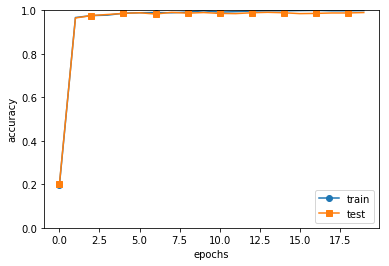

In [12]:

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()



## 7.6 CNNの可視化
* 畳み込み層を可視化することでCNNで何が行われているのかを探索する
### 7.6.1 1層目の重みの可視化

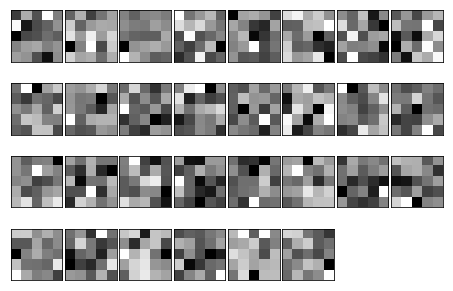

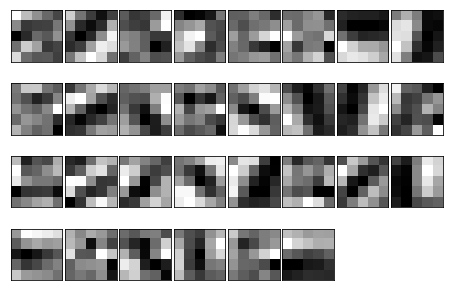

In [13]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))
    
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    
    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

### 7.6.2 階層構造による情報抽出
* 先の結果の考察
  * 1層目の畳み込み層を対象とした結果である
  * 1層目ではエッジやブロブなどの低レベルな情報が抽出される
  * ディープラーニングの可視化に関する研究では，層が深くなるに従い抽出される情報はより抽象化されていくことが示されている
    * AlexNetのネットワーク構成は畳み込み層とプーリング層が何層にも重なり，最後に全結合層を経て結果が出力される
  * 畳み込み層を何層も重ねると，層が深くなるにつれ，より複雑で抽象化された情報が抽出される
  * 最初の層は単純なエッジに反応し，次にテクスチャに反応し，そしてより複雑な物体のパーツへと反応するように変化する
    * 層が深くなるに従い，単純な形状から高度な情報へと変化する．
    * ものの意味を理解するかのように反応する対象が変化する．

## 7.7 代表的なCNN
* CNNは様々な構成のネットワークが提案されてきた
* LeNetおよびAlexNetは特に重要なネットワークである

### 7.7.1 LeNet
* CNNの元祖
* 手書き数字認識を行うネットワークとして1998年に提案された
* 畳み込み層とサブサンプリング層（要素を間引く層）を連続して行い，最後に全結合層を経て結果が出力される
* 現在のCNNとの違い
  * シグモイド関数が使われている（現在は主にReLUが使われる）
  * サブサンプリングによって中間データのサイズを縮小している（現在はMaxプーリングが主流） 

### 7.7.2 AlexNet
* ディープラーニングが注目されるに至ったCNN．2012年に提案された．
* 畳み込み層とプーリング層を重ね，最後に全結合層を経由して結果を出力する
* 基本構成はLeNetと変わらないが，以下の点で異なる
  * ReLUを使用する
  * LRN(Local Response Normalization)という局所的正規化の層を使用する
  * Dropoutを使用する
* LeNetの時代と比べるとコンピューティング環境が変化
  * 大量データの入手が容易になった
  * GPUが普及し，大量の演算を高速に実行可能となった

## 7.8 まとめ
* CNNについて学んだ
  * CNNを構成する基本モジュールは「畳み込み層」と「プーリング層」である
  * CNNはこれまでの全結合層のネットワークに加え，畳み込み層とプーリング層が加わったもの
  * CNNは画像を扱う分野では例外なく使われる
* 畳み込み層とプーリング層はim2colを用いるとシンプルで効率よく実装できる
* CNNの可視化により高度な情報が層を深くするにつれて抽出される様子がわかる
* ディープラーニングの発展にビックデータとGPUが大きく貢献している